<a href="https://colab.research.google.com/github/GiovaniValdrighi/style_transfer/blob/main/notebooks/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

Reprodução do algoritmo de transferência de estilo do artigo  *A Neural Algorithm of Artistic Style*, de Leon A. Gays, Alexander S. Ecker e Matthis Bethge. 

In [2]:
import torch
import urllib
import torch.nn as nn
from PIL import Image
import pickle as pkl
from torchvision import transforms
import torch.optim as optim
from torchvision.models import vgg19
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocess images


In [3]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(path):
    '''Function that load the image and preprocess to the VGG19 format
    The image must be with shape 224x224, with mean [0.485, 0.456, 0.406]
    and standard deviation [0.229, 0.224, 0.225]'''
    img = Image.open(path)
    return preprocess(img).unsqueeze(0)


## Loss functions

In [4]:
def content_loss(pred, target):
    '''The content loss is the mean squared error'''
    return torch.pow(pred - target, 2).mean()

def gram_matrice(input):
    '''
    Compute the gram matrice of the input tensor
    The gram matrice of V is V'V, but we have to change the input to 2 dimensios
    Than we normalize by the number of elements
    '''
    batch, channel, width, height = input.size()
    M = input.view(batch * channel, width * height)
    gram = torch.mm(M, M.t())
    return gram.div(batch*width*height*channel)

def style_loss(pred, gram_target):
    '''The style loss if the euclidian distance of the Gram matrice '''
    gram_pred = gram_matrice(pred)
    return torch.pow(gram_pred - gram_target, 2).mean()

## Model

In [5]:
class vgg19_mod(nn.Module):
    def __init__(self, content_layers, style_layers):
        '''
        Class that initialize the VGG19 model and set the intermediate style and content layers

        Inputs:
            style_layers : list of index of the style layers in the VGG19 net
            content_layers: list of index of the content layers in the VGG19 net
        '''
        super(vgg19_mod, self).__init__()
        features = list(vgg19(pretrained = True).features)
        self.features = nn.ModuleList(features).eval()
        self.style_layers = style_layers
        self.content_layers = content_layers

    def forward(self,  input):
        '''
        Forward process that pass the input image trought the VGG 19 net and keeps the intermediates outputs

        Inputs:
            input : tensor of shape [batch, 3, 224, 224] 

        Outputs:
            style_out : list of style layers outputs
            cotent_out : list of content layers outputs
        '''
        style_out = []
        content_out = []
        for i, model in enumerate(self.features):
            input = model(input)
            if i in self.style_layers:
                style_out.append(input)
            if i in self.content_layers:
                content_out.append(input)
        return content_out, style_out


## Training

In [6]:
def run_style_transfer(content_path, style_path, iterations = 500, content_layers = None, style_layers = None, 
                       content_weight = 1, style_weight = 1000000, verbose = False, cuda = False, return_loss = False):
    '''
    Training process for the neural style transfer VGG19
    The method uses two images, the content and the style image, and generate a image that 
    contain the content and the style of the reespective images
    The optimization is done by LBFGS

    Inputs:
        content_path : path for the content image
        style_path : path for the style image
        iterations: number of iterations to converge
        content_layers : list of index of VGG19 content layers
        style_layers : list of index of VGG19 style layers
        content_weight : weight of the content loss
        style_weight : weight of the style loss
        verbose : if the function will print intermediate steps
        cuda: if the function will process using GPU
        return_loss: if the function will return the loss value for each epoch

    Outputs:
        init_image : result image with content and style

    '''
    if cuda:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if verbose:
            print("Running model with", device)
    else:
        device = torch.device('cpu')

    #Create loss dict
    if return_loss:
        losses = {'style_loss': [], 'content_loss': [], 'total_loss':[]}

    #Setting intermediate layers
    if content_layers is None:
        content_layers = [9]

    if style_layers is None:
        style_layers = [0, 3, 6, 9, 14]

    #Loading the model
    model = vgg19_mod(content_layers, style_layers).to(device)
        
    if verbose:
        print('Initialized model.')

    #Loading the images as tensors
    content_img = load_image(content_path).to(device)
    style_img = load_image(style_path).to(device)
    init_img = load_image(content_path).to(device)
    if verbose:
        print('Initialized images.')

    #Getting the content and style outputs
    content_out, _ = model(content_img)
    _, style_out = model(style_img)
    if verbose:
        print('Calculated images outputs.')

    #Pre-calculating the gram matrice for the styles outputs
    gram_out = [gram_matrice(out) for out in style_out]

    #Setting optmizer
    optmizer = optim.LBFGS([init_img.requires_grad_()])
    if verbose:
        print('Starting optimization.')
    for iter in tqdm(range(iterations)):
        if return_loss:
            _iter_style_loss = []
            _iter_content_loss = []
            _iter_total_loss = []

        def closure():
            '''Calculate ouputs, loss and gradients'''
            optmizer.zero_grad()

            init_content_out, init_style_out = model(init_img)
            
            _content_loss = 0
            for l in range(len(content_out)):
                _content_loss += content_loss(init_content_out[l], content_out[l])

            _style_loss = 0
            for l in range(len(style_out)):
                _style_loss += style_loss(init_style_out[l],  gram_out[l])

            _content_loss *= content_weight
            _style_loss *= style_weight

            loss = _content_loss + _style_loss

            loss.backward(retain_graph=True)

            if iter % 100 == 0 and iter > 0:
                if verbose:
                    print('Iteration %d.  Model loss %.8f'%(iter, loss))
                    print('Content loss: %.8f | Style loss: %.8f'%(_content_loss, _style_loss))
                    print()

            #Update loss dict
            if return_loss:
                _iter_style_loss.append(_style_loss.clone().data.cpu().numpy())
                _iter_content_loss.append(_content_loss.clone().data.cpu().numpy())
                _iter_total_loss.append(loss.clone().data.cpu().numpy())
            
            return _content_loss + _style_loss
        optmizer.step(closure)
        if return_loss:
            losses['style_loss'].append(_iter_style_loss[-1])
            losses['content_loss'].append(_iter_content_loss[-1])
            losses['total_loss'].append(_iter_total_loss[-1])
            

    #Invert VGG19 input transformation
    invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                   transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ])])
    inv_img = invTrans(init_img.squeeze(0))
    
    if return_loss:
        return inv_img, losses
    else:
        return inv_img

## Training with content and style image

In [ ]:
cat_path = '/content/cat.jpg'
stary_night_path = '/content/stary_night.jpg'
cat_stary_dict = {}
for ratio in [1e5, 1e6, 1e7]:
    cat_stary_dict[ratio] = run_style_transfer(cat_path, stary_night_path, 
                                                             verbose = False, cuda = True,
                                                             content_weight = 1,
                                                             style_weight = ratio)

## Visualizing the results

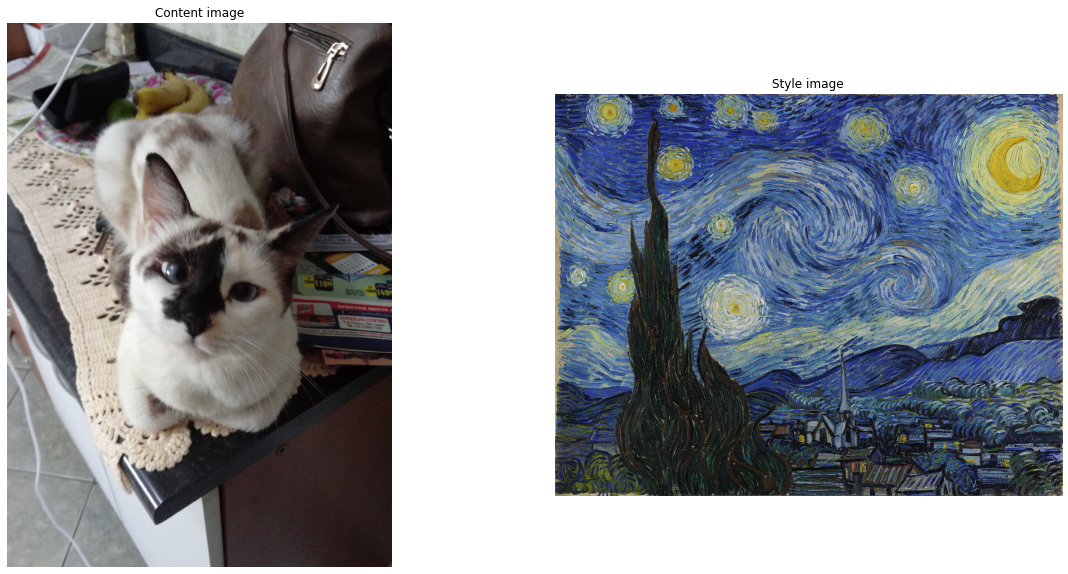

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open('cat.jpg')
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open('stary_night.jpg')
ax[1].imshow(style_image)
ax[1].axis('off')
plt.show()

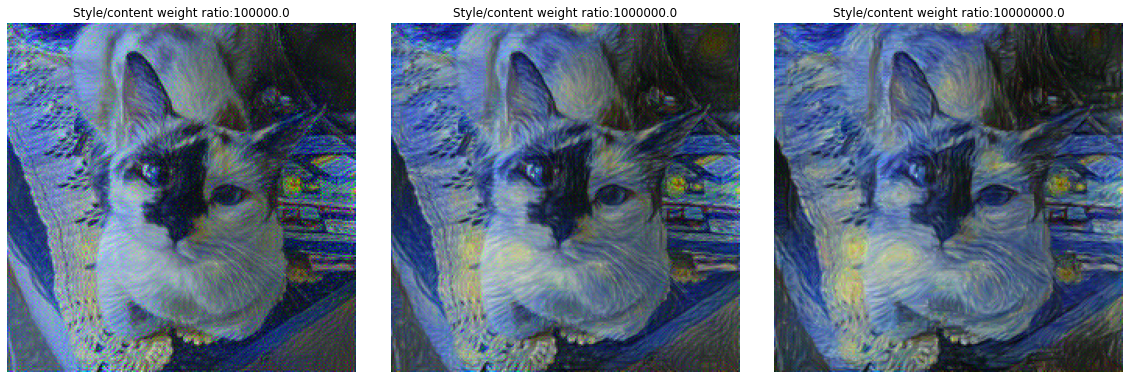

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(20)
fig.set_figheight(12)
for i, ratio in enumerate([1e5, 1e6, 1e7]):
    img = cat_stary_dict[ratio].cpu().detach().permute(1, 2, 0).data.clamp_(0, 1).numpy()
    #img -= img.min()
    #img /= img.max()
    #print(img.min(), img.max())
    ax[i].imshow(img)
    ax[i].set_title("Style/content weight ratio:" + str(ratio))
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()

## Test with another images

In [ ]:
dog_path = '/content/little_dog.jpg'
grito_path = '/content/grito.jpg'
dog_grito_dict = {}
for ratio in [1e5, 1e6, 1e7]:
    dog_grito_dict[ratio] = run_style_transfer(dog_path, grito_path, 
                                                             verbose = False, cuda = True,
                                                             content_weight = 1,
                                                             style_weight = ratio)

In [ ]:
with open("dog_grito_dict.pkl", "wb") as f:
    pkl.dump(dog_grito_dict, f)

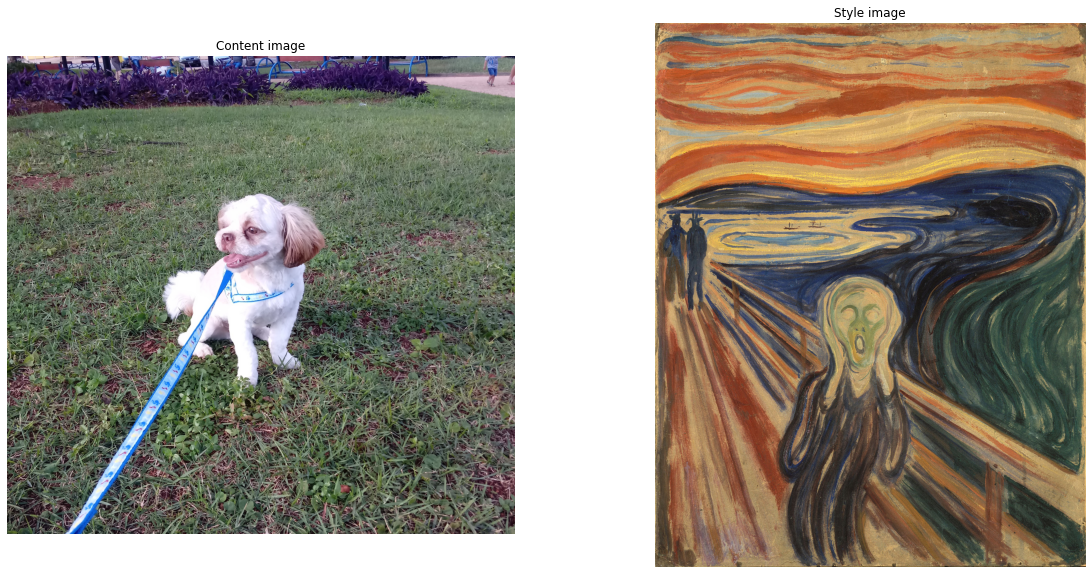

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Content image')
content_image = Image.open('little_dog.jpg')
ax[0].imshow(content_image)
ax[0].axis('off')

ax[1].set_title("Style image")
style_image = Image.open('grito.jpg')
ax[1].imshow(style_image)
ax[1].axis('off')
plt.show()

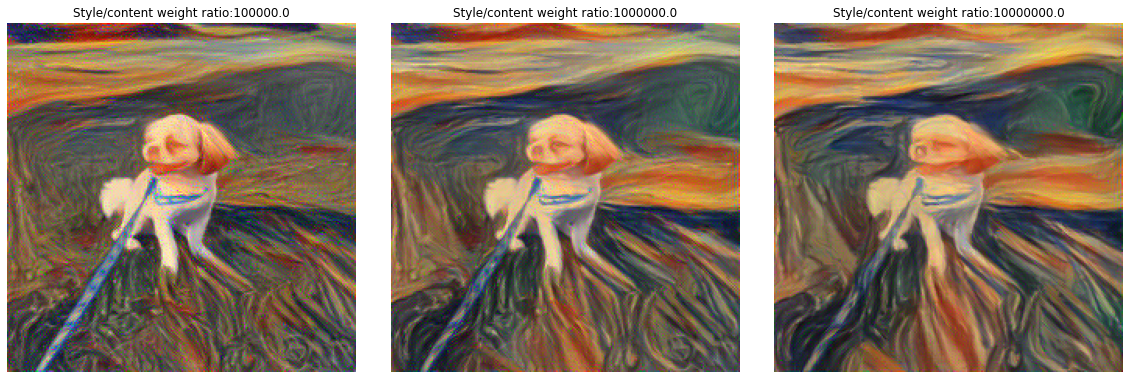

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3)
fig.set_figwidth(20)
fig.set_figheight(12)
for i, ratio in enumerate([1e5, 1e6, 1e7]):
    img = dog_grito_dict[ratio].cpu().detach().permute(1, 2, 0).data.clamp_(0, 1).numpy()
    #img -= img.min()
    #img /= img.max()
    #print(img.min(), img.max())
    ax[i].imshow(img)
    ax[i].set_title("Style/content weight ratio:" + str(ratio))
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.05)
plt.show()

## Análise do treinamento

Vamos começar observando o comportamento da loss ao decorrer das iterações e encontrar o número de iterações que otimiza o tempo de processamento e o valor da loss. Queremos obter esse valor ótimo para sermos capazes de processar uma grande quantidade de imagens, como é necessário ao aplicarmos o método em um vídeo.

In [8]:
cat_stary, cat_stary_loss = run_style_transfer('cat.jpg', 'stary_night.jpg', iterations = 1000, 
                                               cuda = True, return_loss = True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


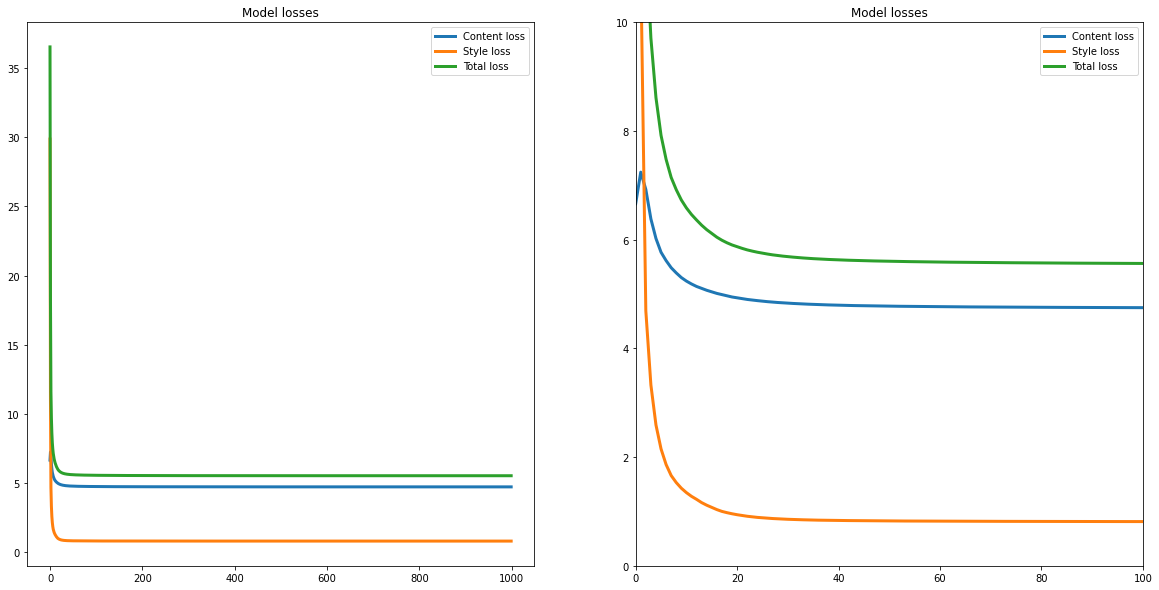

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
fig.set_figwidth(20)
fig.set_figheight(10)

ax[0].set_title('Model losses')
ax[0].plot(list(range(len(cat_stary_loss['content_loss']))), cat_stary_loss['content_loss'],
           linewidth = 3, label = 'Content loss')
ax[0].plot(list(range(len(cat_stary_loss['style_loss']))), cat_stary_loss['style_loss'],
           linewidth = 3, label = 'Style loss')
ax[0].plot(list(range(len(cat_stary_loss['total_loss']))), cat_stary_loss['total_loss'],
           linewidth = 3, label = 'Total loss')

ax[0].legend()

ax[1].set_title("Style loss")
ax[1].set_title('Model losses')
ax[1].plot(list(range(len(cat_stary_loss['content_loss']))), cat_stary_loss['content_loss'],
           linewidth = 3, label = 'Content loss')
ax[1].plot(list(range(len(cat_stary_loss['style_loss']))), cat_stary_loss['style_loss'],
           linewidth = 3, label = 'Style loss')
ax[1].plot(list(range(len(cat_stary_loss['total_loss']))), cat_stary_loss['total_loss'],
           linewidth = 3, label = 'Total loss')
ax[1].set_ylim(0, 10)
ax[1].set_xlim(0, 100)
ax[1].legend()

plt.show()

Vemos que o método tem uma rápida convergência, mantendo o mesmo valor da loss para todas as iterações após as 30 primeiras. Dessa forma, podemos realizar o treinamento com apenas 30 iterações para evitar extra processamento.